In [1]:
import sys
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path

input_size=40
train_size=128
validation_size=200
data_path='/mnt/data/kjetil/deleteme/kh_1.nc'

Using TensorFlow backend.


In [2]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
    def area(self, I):
        
        return 4*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    

In [3]:
def get_samples(data_path, functional):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                samples.append(functional(f.variables[k][:,:,0]))
    
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

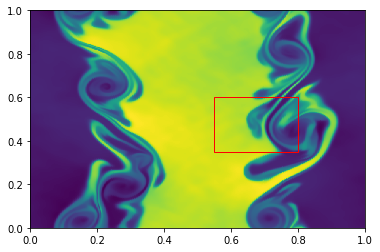

In [4]:
draw_functional(data_path, AreaFunctional())

In [5]:
def get_network_from_functional(data_path, functional, parameters, epochs=500000):
    samples = get_samples(data_path, functional)
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size, epochs=epochs,
                      title=functional.title())
def get_network_from_functional_qmc(data_path, functional,epochs=500000):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)
    
    return get_network_from_functional(data_path, functional, parameters, epochs)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000, title=''):
    import numpy as np
    
    print(type(data))
    print(data.shape)
    if np.isnan(data).any():
        print("We have a nan!")
    if np.isinf(data).any():
        print("we have an inf!")
        
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(20, input_shape=(input_size,)),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(22),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
   
    epochs_r=range(1, epochs)
   
    hist = model.fit(x_train, y_train,batch_size=train_size, epochs=epochs,shuffle=True,
          validation_data=(x_val, y_val),verbose=0)
    plt.loglog(hist.history['loss'])
    plt.title("Training loss\n%s\n(epochs=%d)" % (title, epochs))
    saveAndShow("training_loss")
    
    plt.loglog(hist.history['val_loss'])
    plt.title("Validation loss\n%s\n(epochs=%d)" % (title, epochs))
    saveAndShow("training_loss")
    x_test = parameters
    y_test = data
    y_predict = model.predict(x_test)
    print(y_test.shape)
    print(y_predict.shape)
    plt.scatter(y_test, y_predict[:,0])
    plt.title("Scatter plot, \n%s,\n epochs=%d" % (title, epochs))
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    saveAndShow("scatter_ml")
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data, parameters

In [ ]:
def get_network_interpolate_qmc(data_path, functional, epochs=500000):
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional, epochs)
    
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    y_train = data[:train_size]
    coeffs = reg.fit(parameters[:train_size,:], y_train)

    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear least squares\n%s' % functional.title())
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    plt.show()
    
    def myvar(x):
        mean = sum(x)/x.shape[0]
        var = sum((mean-x)**2)/x.shape[0]
        return var
    
    def mymean (x): 
        return sum(x)/x.shape[0]
    
    
   
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = network.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data- predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = mymean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = mymean(network.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = mymean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    print("mean_lsq = %f" % mean(evaluated_lsq))
    
    
    
    
    predicted_all = network.predict(parameters)
    predicted_all = predicted_all.reshape(parameters.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = myvar(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = myvar(network.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = myvar(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    print("var_lsq = %f" % var(evaluated_lsq))
    
    title = functional.title()
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.title("Comparison QMC and Machine learning\n%s\nepochs=%d"% (title, epochs))
    plt.hist(network.predict(parameters),bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml')
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(8192, train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc')
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC 8192 samples',alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq')
    
    return network, data, parameters

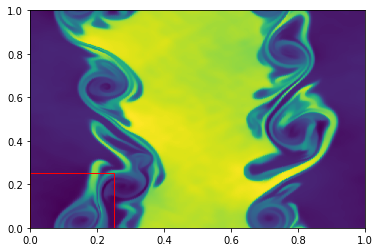

0.25041064735644436
[[0, 0], [128, 128]]
65536
0.2646956684845577
[[0, 0], [128, 128]]
65536
0.3011160991879366
[[0, 0], [128, 128]]
65536
0.30389016799630225
[[0, 0], [128, 128]]
65536
0.2790202036408604
[[0, 0], [128, 128]]
65536
0.30671866557091976
[[0, 0], [128, 128]]
65536
0.26932298052958303
[[0, 0], [128, 128]]
65536
0.30489490059018864
[[0, 0], [128, 128]]
65536
0.2730903957353397
[[0, 0], [128, 128]]
65536
0.3070321262676823
[[0, 0], [128, 128]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


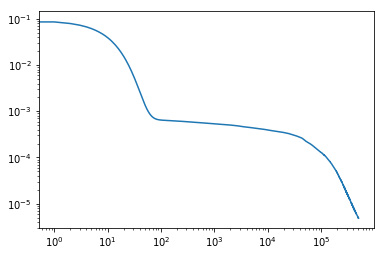

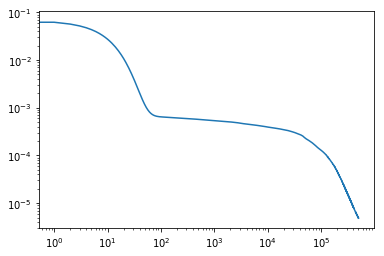

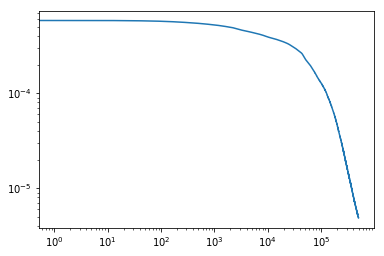

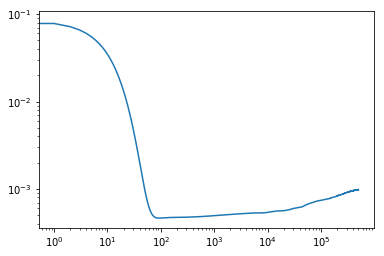

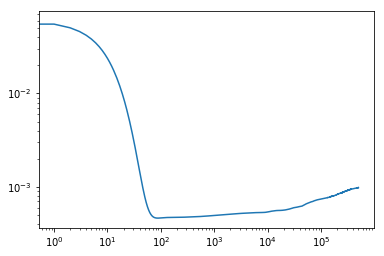

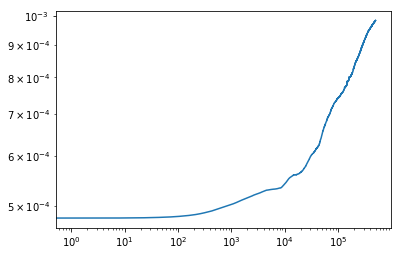

(8192,)
(8192, 1)


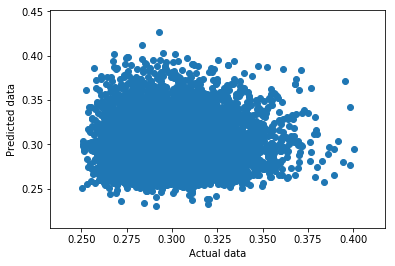

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_2 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                460       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 22)                462       
__________

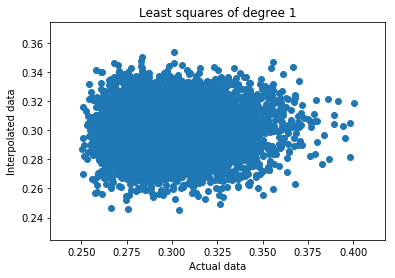

variance single level = 0.000485
variance diff ml = 0.001128 
speedup = 0.214828
(8192,)
variance_diff_interpolate = 0.000698
mean_qmc = 0.298482
mean_ml = 0.300979
mean_few_qmc = 19.843750
mean_lsq = 0.299919
(8192,)
mean_mlmlmc = 0.300980
var_qmc = 0.000485
var_ml = 0.000663
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000229
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


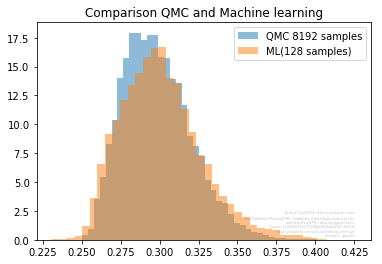

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


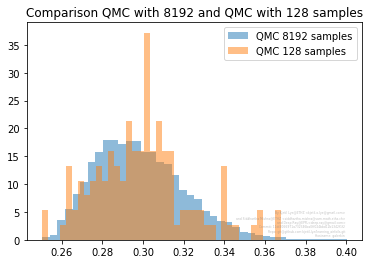

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


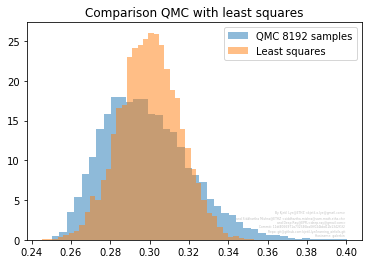

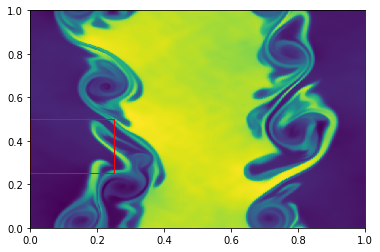

0.25041064735644436
[[0, 128], [128, 256]]
65536
0.2983753827435298
[[0, 128], [128, 256]]
65536
0.3192724063910527
[[0, 128], [128, 256]]
65536
0.2818235362731477
[[0, 128], [128, 256]]
65536
0.28414491076997217
[[0, 128], [128, 256]]
65536
0.2642755221539912
[[0, 128], [128, 256]]
65536
0.2925005232071821
[[0, 128], [128, 256]]
65536
0.2957547419857226
[[0, 128], [128, 256]]
65536
0.35557404576302376
[[0, 128], [128, 256]]
65536
0.3150518033704351
[[0, 128], [128, 256]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


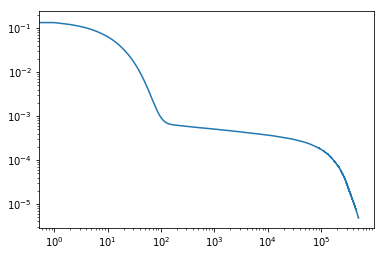

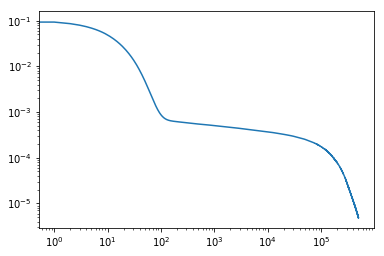

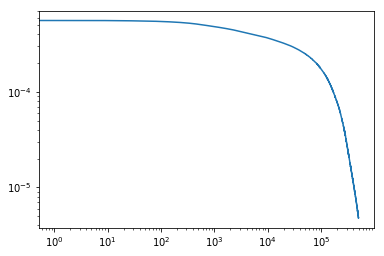

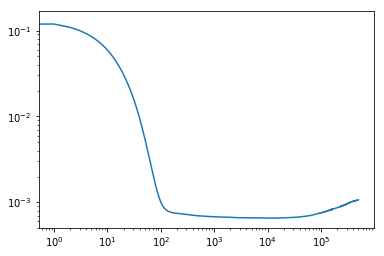

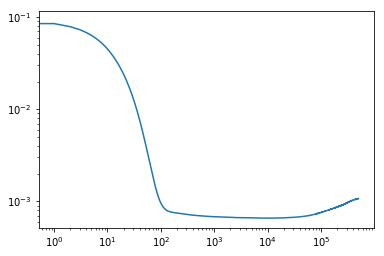

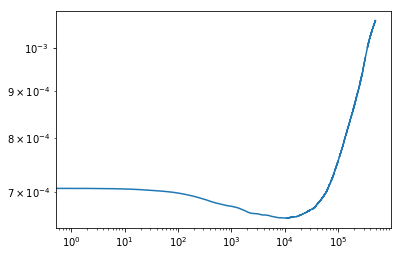

(8192,)
(8192, 1)


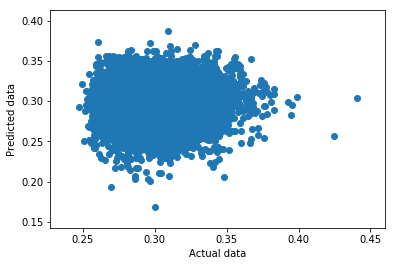

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                820       
_________________________________________________________________
activation_7 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 22)                462       
_________________________________________________________________
activation_8 (Activation)    (None, 22)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_9 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 22)                462       
__________

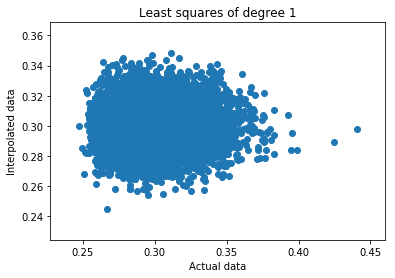

variance single level = 0.000491
variance diff ml = 0.001024 
speedup = 0.239616
(8192,)
variance_diff_interpolate = 0.000682
mean_qmc = 0.298271
mean_ml = 0.298489
mean_few_qmc = 19.843750
mean_lsq = 0.300698
(8192,)
mean_mlmlmc = 0.298490
var_qmc = 0.000491
var_ml = 0.000549
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000192
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


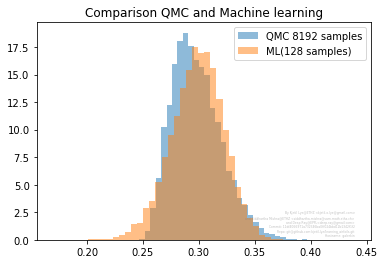

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


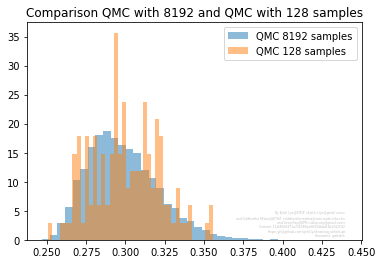

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


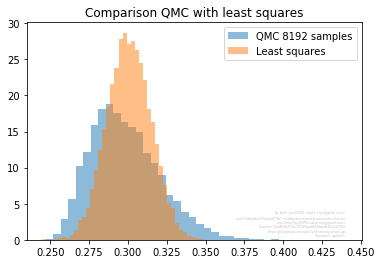

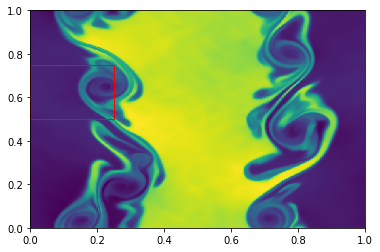

0.25041064735644436
[[0, 256], [128, 384]]
65536
0.2780394361164335
[[0, 256], [128, 384]]
65536
0.2796383329926381
[[0, 256], [128, 384]]
65536
0.2770264327056581
[[0, 256], [128, 384]]
65536
0.2951147089682897
[[0, 256], [128, 384]]
65536
0.3090987464877111
[[0, 256], [128, 384]]
65536
0.30808211214976955
[[0, 256], [128, 384]]
65536
0.2835944355149732
[[0, 256], [128, 384]]
65536
0.33353005696868265
[[0, 256], [128, 384]]
65536
0.2849365784861442
[[0, 256], [128, 384]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


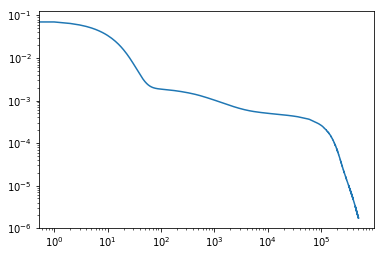

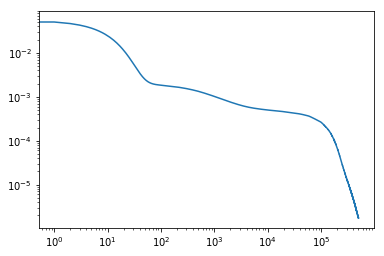

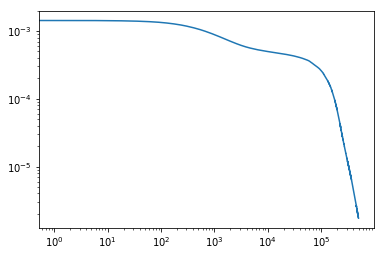

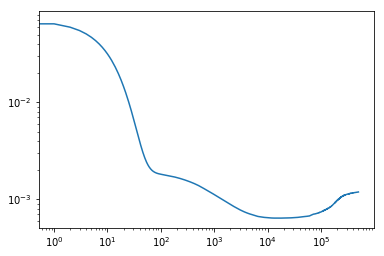

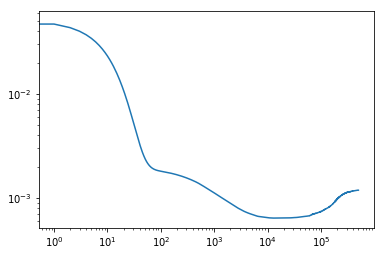

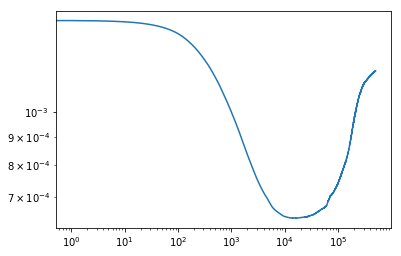

(8192,)
(8192, 1)


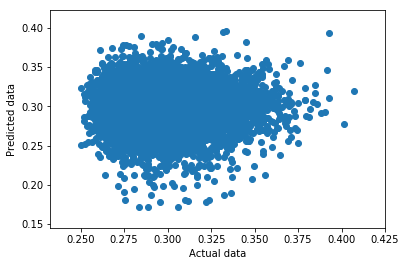

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_13 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_14 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_15 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 22)                462       
__________

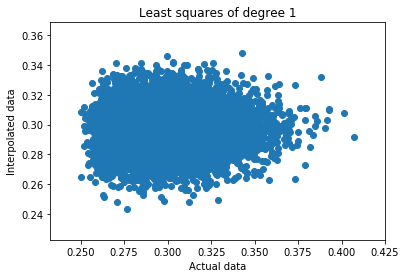

variance single level = 0.000492
variance diff ml = 0.001121 
speedup = 0.219354
(8192,)
variance_diff_interpolate = 0.000686
mean_qmc = 0.298235
mean_ml = 0.299205
mean_few_qmc = 19.843750
mean_lsq = 0.297093
(8192,)
mean_mlmlmc = 0.299206
var_qmc = 0.000492
var_ml = 0.000635
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000207
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


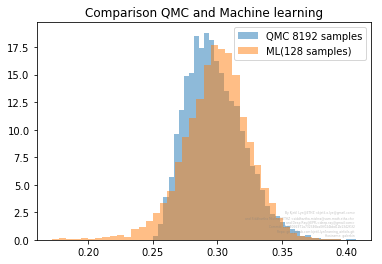

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


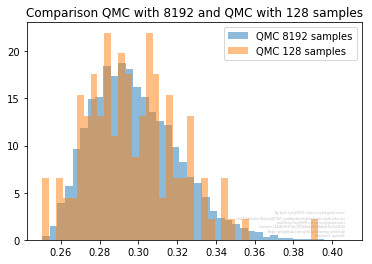

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


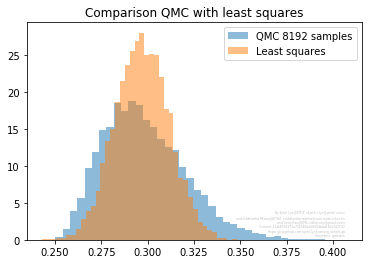

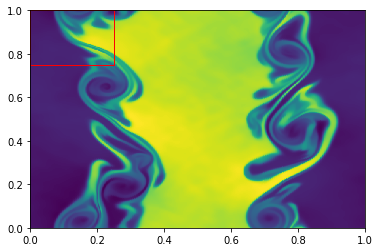

0.25041064735644436
[[0, 384], [128, 512]]
65536
0.2926230053730735
[[0, 384], [128, 512]]
65536
0.27672152823139246
[[0, 384], [128, 512]]
65536
0.32175594965506066
[[0, 384], [128, 512]]
65536
0.3084924771103993
[[0, 384], [128, 512]]
65536
0.3129559976884301
[[0, 384], [128, 512]]
65536
0.32885613026657895
[[0, 384], [128, 512]]
65536
0.2853897389454044
[[0, 384], [128, 512]]
65536
0.28065831896542975
[[0, 384], [128, 512]]
65536
0.32726142260640895
[[0, 384], [128, 512]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


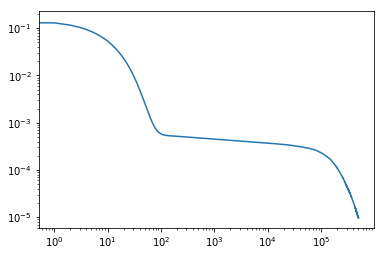

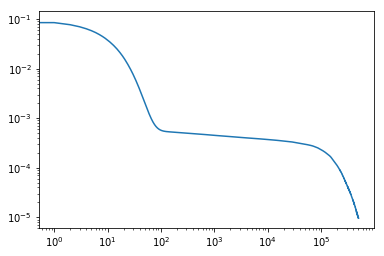

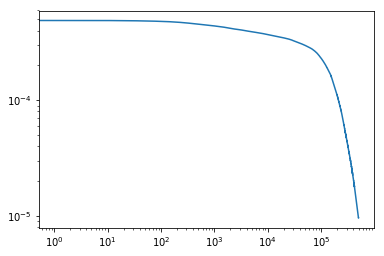

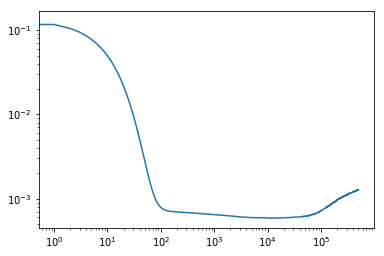

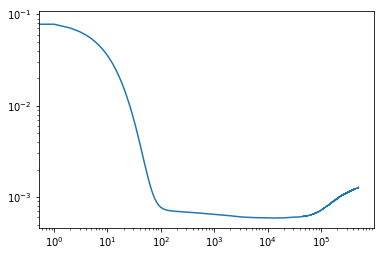

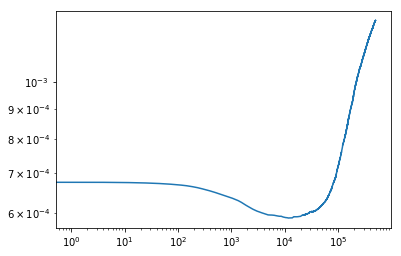

(8192,)
(8192, 1)


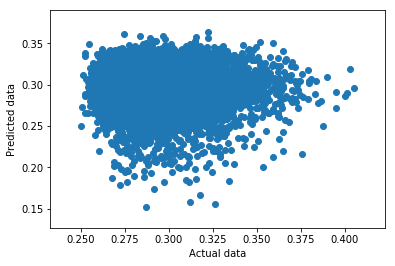

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_19 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_20 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_21 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 22)                462       
__________

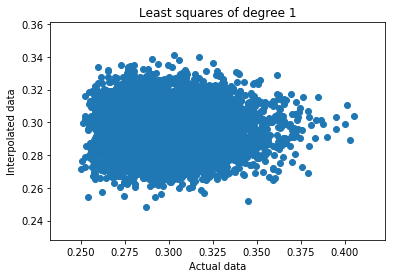

variance single level = 0.000490
variance diff ml = 0.001014 
speedup = 0.241736
(8192,)
variance_diff_interpolate = 0.000653
mean_qmc = 0.298132
mean_ml = 0.294394
mean_few_qmc = 19.843750
mean_lsq = 0.295984
(8192,)
mean_mlmlmc = 0.294395
var_qmc = 0.000490
var_ml = 0.000523
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000163
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


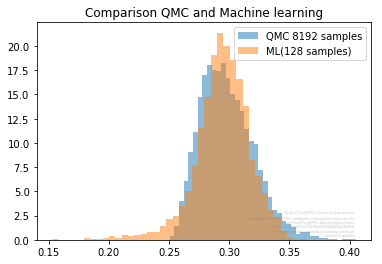

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


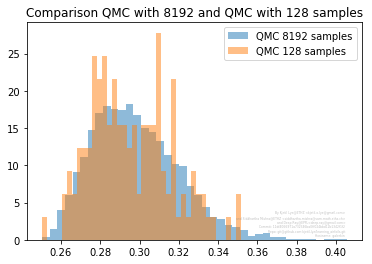

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


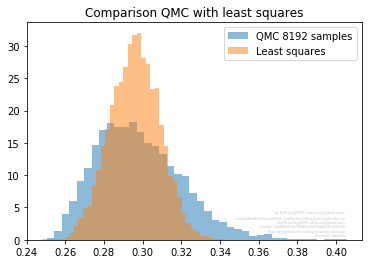

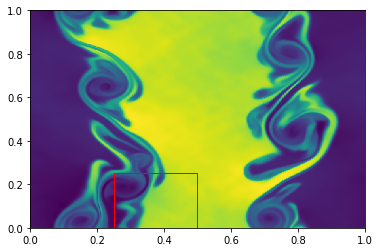

0.49958935264355625
[[128, 0], [256, 128]]
65536
0.45858173634535393
[[128, 0], [256, 128]]
65536
0.48741237101026536
[[128, 0], [256, 128]]
65536
0.46048508298703705
[[128, 0], [256, 128]]
65536
0.44106850297782685
[[128, 0], [256, 128]]
65536
0.42716243763397393
[[128, 0], [256, 128]]
65536
0.3956216395726476
[[128, 0], [256, 128]]
65536
0.48709738008291104
[[128, 0], [256, 128]]
65536
0.4156429997527181
[[128, 0], [256, 128]]
65536
0.47950098020132975
[[128, 0], [256, 128]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


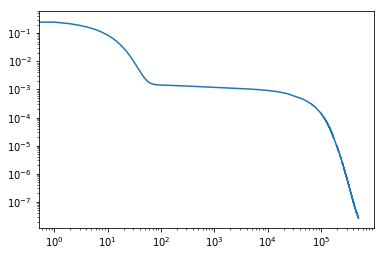

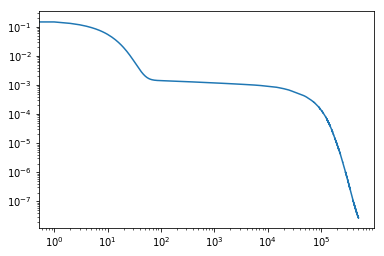

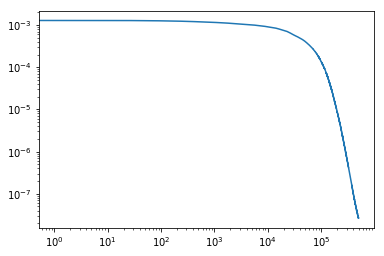

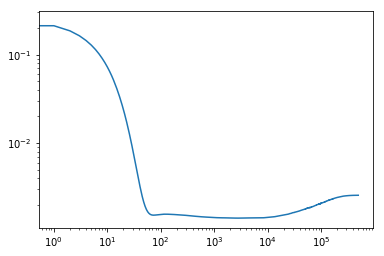

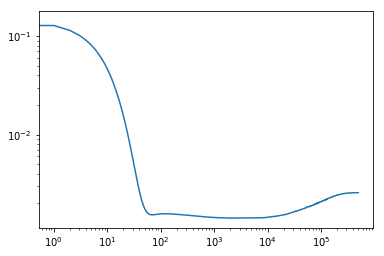

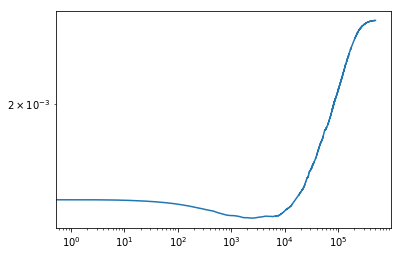

(8192,)
(8192, 1)


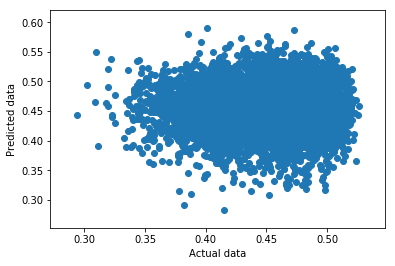

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_25 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_26 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_27 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 22)                462       
__________

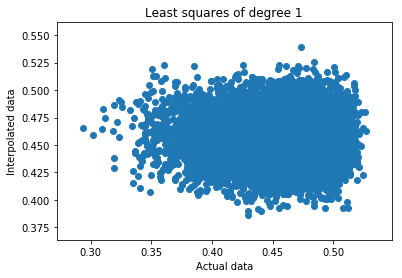

variance single level = 0.001308
variance diff ml = 0.002577 
speedup = 0.253723
(8192,)
variance_diff_interpolate = 0.001787
mean_qmc = 0.452236
mean_ml = 0.454878
mean_few_qmc = 19.843750
mean_lsq = 0.457189
(8192,)
mean_mlmlmc = 0.454878
var_qmc = 0.001308
var_ml = 0.001328
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000458
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


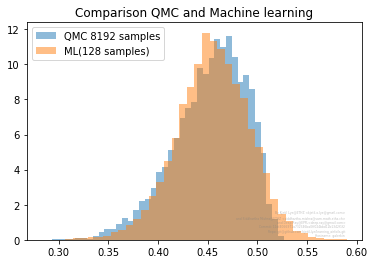

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


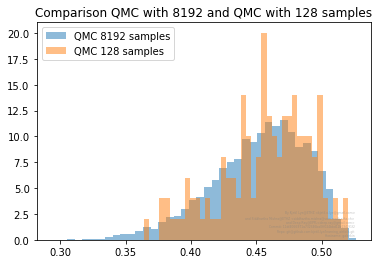

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


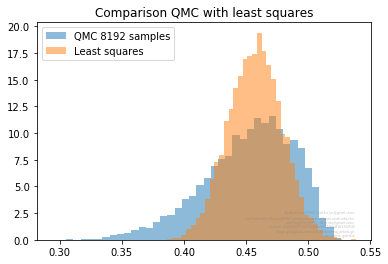

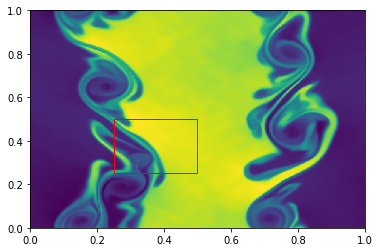

0.49958935264355625
[[128, 128], [256, 256]]
65536
0.4749586741544904
[[128, 128], [256, 256]]
65536
0.4688612092518305
[[128, 128], [256, 256]]
65536
0.45426332402723274
[[128, 128], [256, 256]]
65536
0.47646589550748136
[[128, 128], [256, 256]]
65536
0.41176579092318677
[[128, 128], [256, 256]]
65536
0.4784337773020015
[[128, 128], [256, 256]]
65536
0.47030272603880674
[[128, 128], [256, 256]]
65536
0.47041369876178013
[[128, 128], [256, 256]]
65536
0.40835382738217363
[[128, 128], [256, 256]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


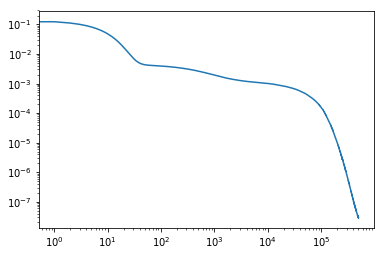

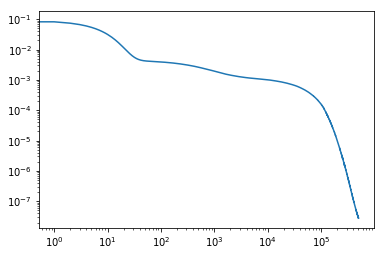

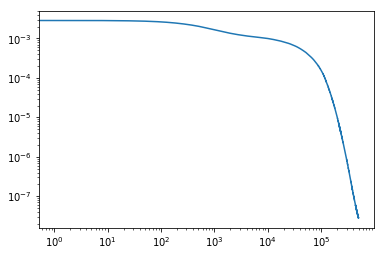

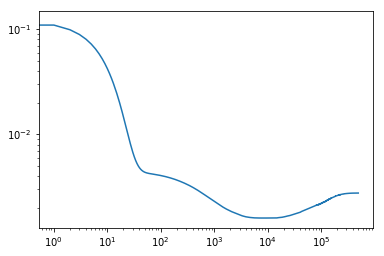

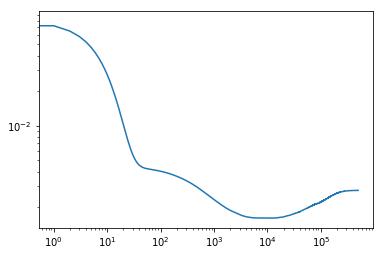

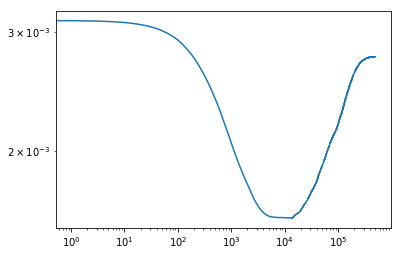

(8192,)
(8192, 1)


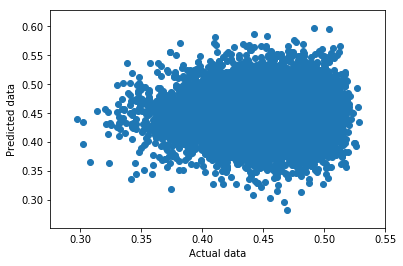

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_31 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_32 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_33 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 22)                462       
__________

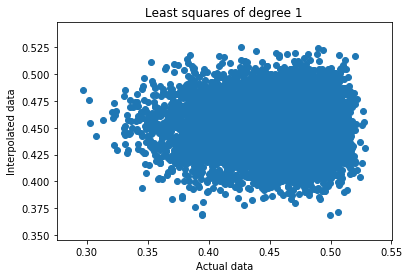

variance single level = 0.001317
variance diff ml = 0.002757 
speedup = 0.238771
(8192,)
variance_diff_interpolate = 0.001845
mean_qmc = 0.452045
mean_ml = 0.449525
mean_few_qmc = 19.843750
mean_lsq = 0.450814
(8192,)
mean_mlmlmc = 0.449525
var_qmc = 0.001317
var_ml = 0.001497
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000536
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


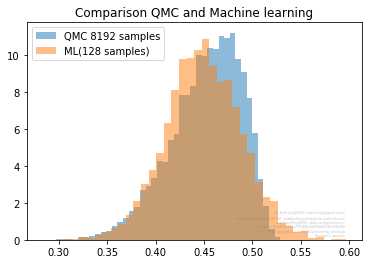

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


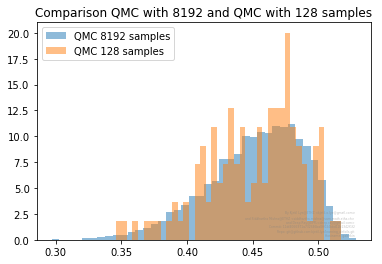

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


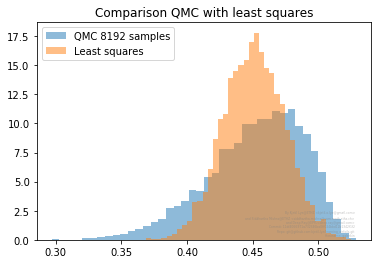

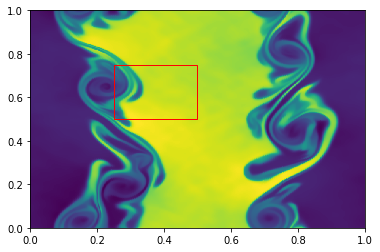

0.49958935264355625
[[128, 256], [256, 384]]
65536
0.47197750181819553
[[128, 256], [256, 384]]
65536
0.47095134628905966
[[128, 256], [256, 384]]
65536
0.4765435301152036
[[128, 256], [256, 384]]
65536
0.47080112731939844
[[128, 256], [256, 384]]
65536
0.49406857469066745
[[128, 256], [256, 384]]
65536
0.48668779832946385
[[128, 256], [256, 384]]
65536
0.40372202045446237
[[128, 256], [256, 384]]
65536
0.46699306032777854
[[128, 256], [256, 384]]
65536
0.44673384393520954
[[128, 256], [256, 384]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


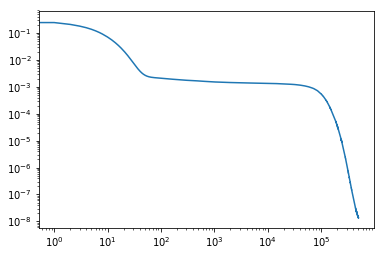

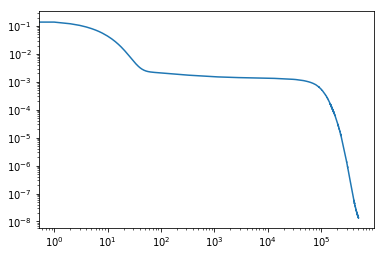

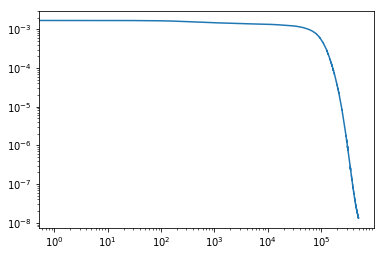

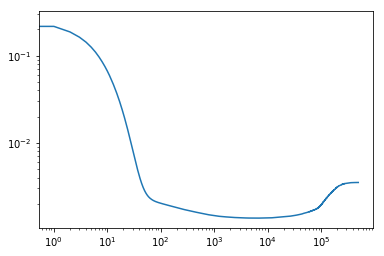

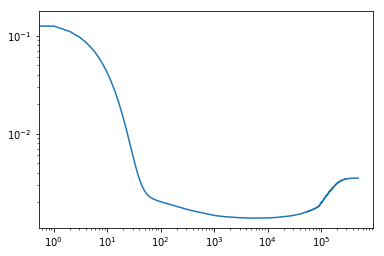

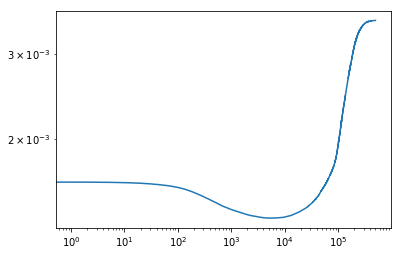

(8192,)
(8192, 1)


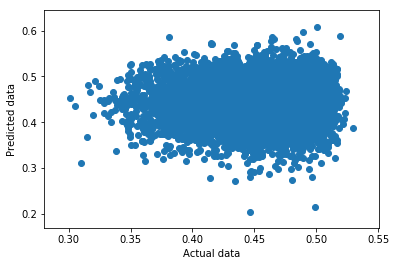

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_37 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_38 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_39 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 22)                462       
__________

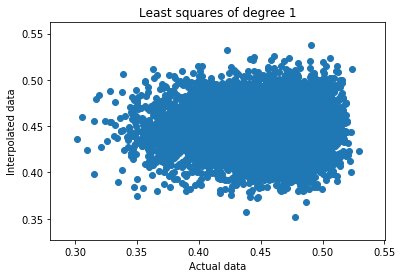

variance single level = 0.001299
variance diff ml = 0.003198 
speedup = 0.203107
(8192,)
variance_diff_interpolate = 0.001855
mean_qmc = 0.451353
mean_ml = 0.444642
mean_few_qmc = 19.843750
mean_lsq = 0.447798
(8192,)
mean_mlmlmc = 0.444642
var_qmc = 0.001299
var_ml = 0.001920
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000571
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


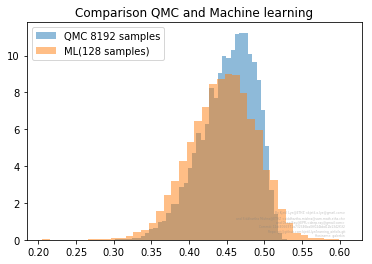

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


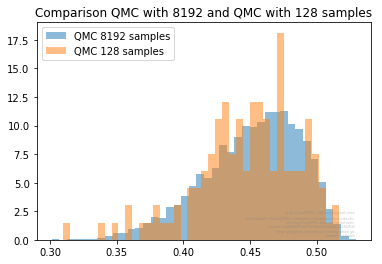

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


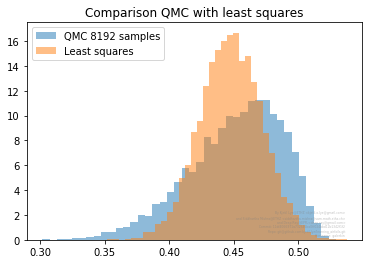

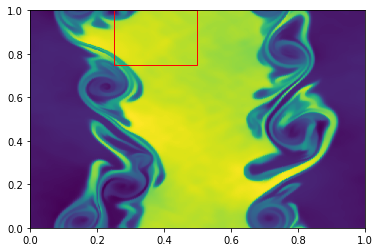

0.49958935264355625
[[128, 384], [256, 512]]
65536
0.47209454907851744
[[128, 384], [256, 512]]
65536
0.3721022113677074
[[128, 384], [256, 512]]
65536
0.44905393366846896
[[128, 384], [256, 512]]
65536
0.4613938873331237
[[128, 384], [256, 512]]
65536
0.47125187418030173
[[128, 384], [256, 512]]
65536
0.44146917873406505
[[128, 384], [256, 512]]
65536
0.4677907372115376
[[128, 384], [256, 512]]
65536
0.3502198476640981
[[128, 384], [256, 512]]
65536
0.41105294262871606
[[128, 384], [256, 512]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


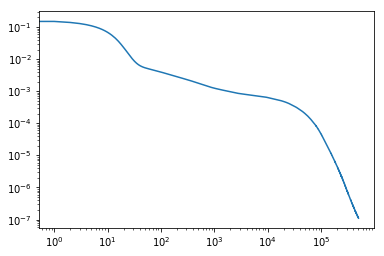

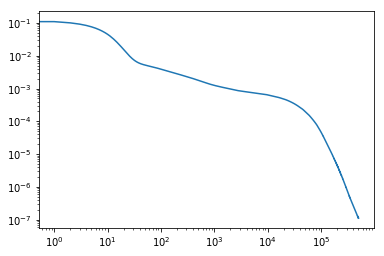

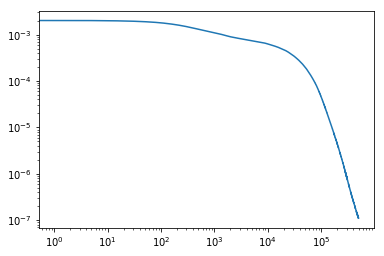

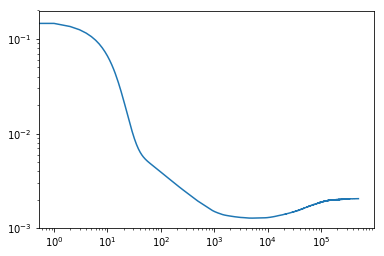

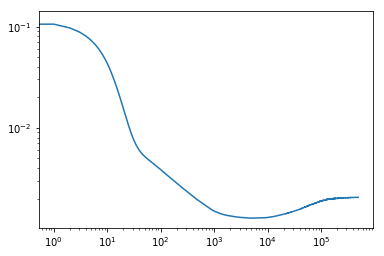

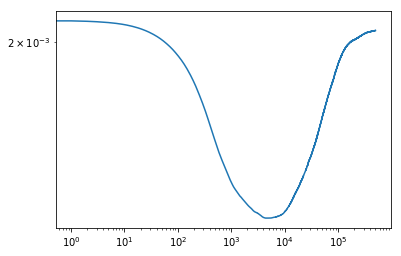

(8192,)
(8192, 1)


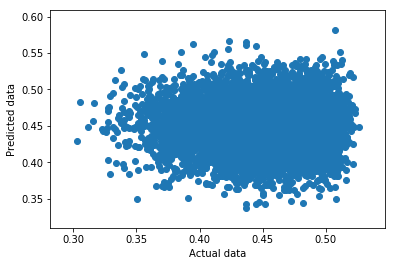

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_43 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_44 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_45 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 22)                462       
__________

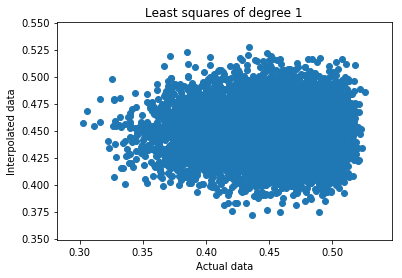

variance single level = 0.001352
variance diff ml = 0.002330 
speedup = 0.290045
(8192,)
variance_diff_interpolate = 0.001841
mean_qmc = 0.451176
mean_ml = 0.450639
mean_few_qmc = 19.843750
mean_lsq = 0.450144
(8192,)
mean_mlmlmc = 0.450639
var_qmc = 0.001352
var_ml = 0.001004
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000498
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


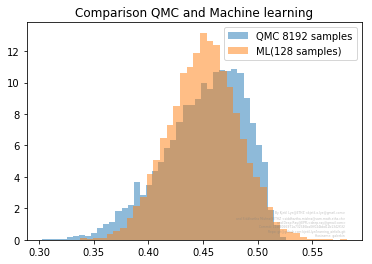

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


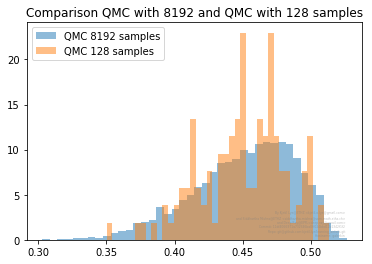

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


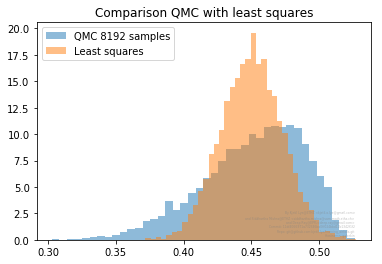

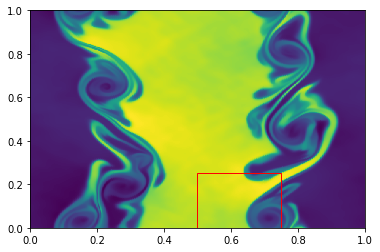

0.4995893526435569
[[256, 0], [384, 128]]
65536
0.4671513846159958
[[256, 0], [384, 128]]
65536
0.39649817123242
[[256, 0], [384, 128]]
65536
0.5145354655217804
[[256, 0], [384, 128]]
65536
0.41481538378547067
[[256, 0], [384, 128]]
65536
0.47400197625702933
[[256, 0], [384, 128]]
65536
0.4578627240692933
[[256, 0], [384, 128]]
65536
0.4543697127148777
[[256, 0], [384, 128]]
65536
0.47282929249944045
[[256, 0], [384, 128]]
65536
0.47652006322350104
[[256, 0], [384, 128]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


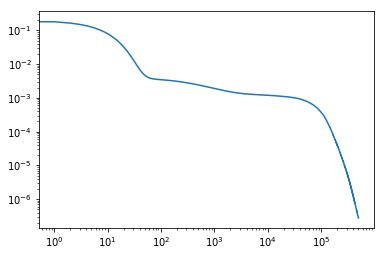

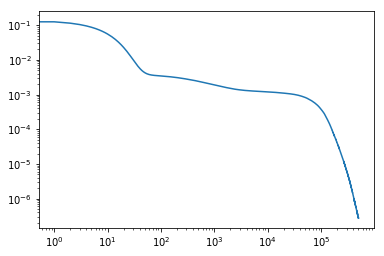

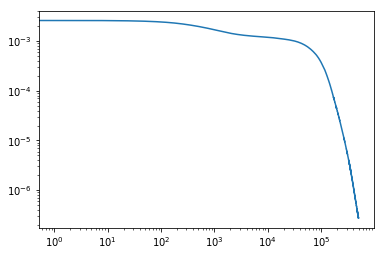

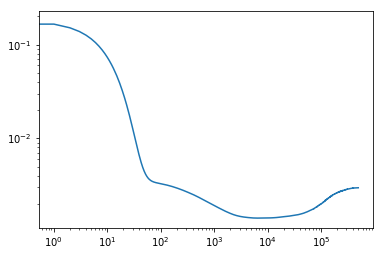

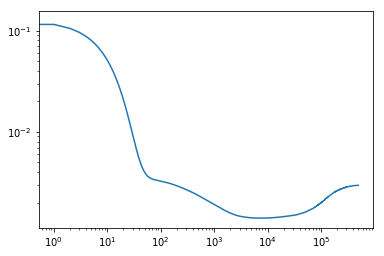

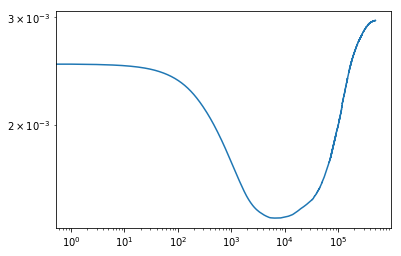

(8192,)
(8192, 1)


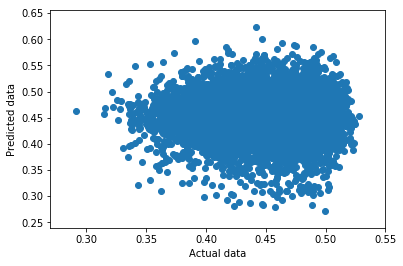

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_49 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_50 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_51 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 22)                462       
__________

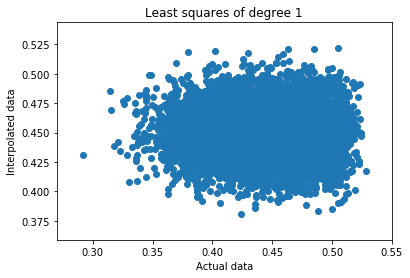

variance single level = 0.001343
variance diff ml = 0.002911 
speedup = 0.230756
(8192,)
variance_diff_interpolate = 0.001780
mean_qmc = 0.450964
mean_ml = 0.453174
mean_few_qmc = 19.843750
mean_lsq = 0.450719
(8192,)
mean_mlmlmc = 0.453175
var_qmc = 0.001343
var_ml = 0.001588
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000416
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


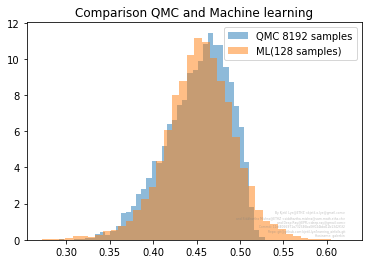

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


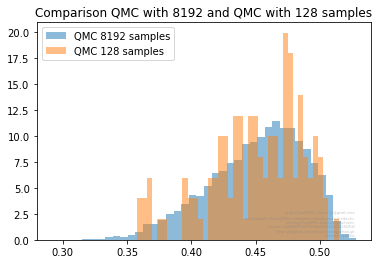

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


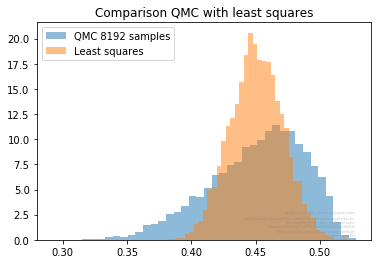

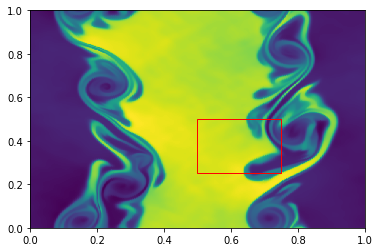

0.4995893526435569
[[256, 128], [384, 256]]
65536
0.43711393071661586
[[256, 128], [384, 256]]
65536
0.48861979678188794
[[256, 128], [384, 256]]
65536
0.4645356273720338
[[256, 128], [384, 256]]
65536
0.5028791763929384
[[256, 128], [384, 256]]
65536
0.45673133705585534
[[256, 128], [384, 256]]
65536
0.49035825960644913
[[256, 128], [384, 256]]
65536
0.44705576043497064
[[256, 128], [384, 256]]
65536
0.42173120053482416
[[256, 128], [384, 256]]
65536
0.47197078143857474
[[256, 128], [384, 256]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


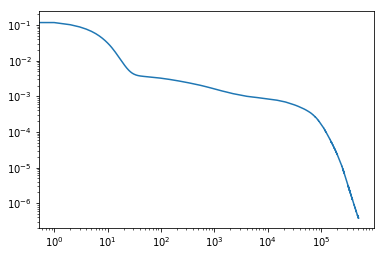

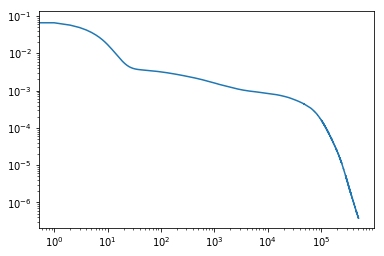

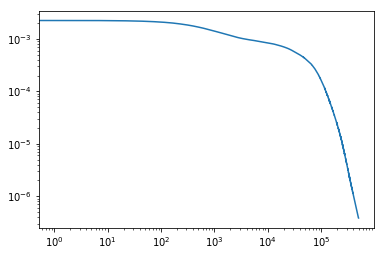

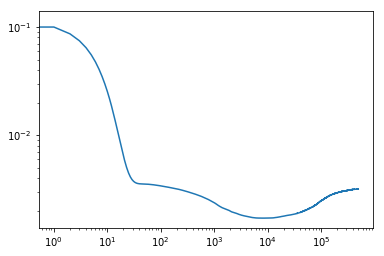

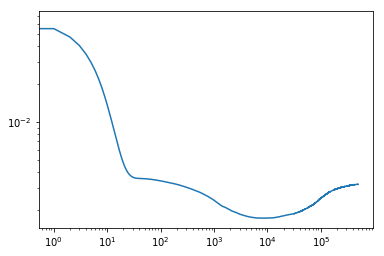

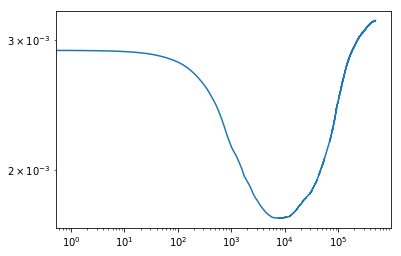

(8192,)
(8192, 1)


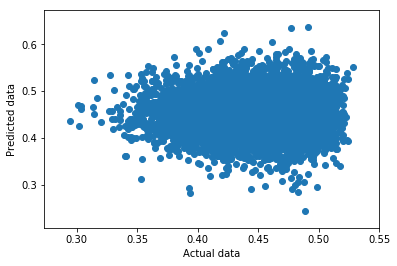

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_55 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_56 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_57 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 22)                462       
__________

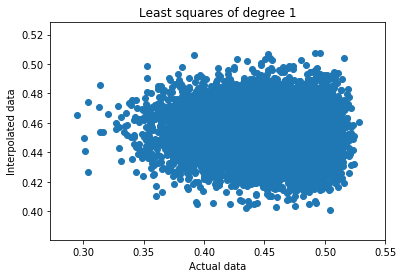

variance single level = 0.001291
variance diff ml = 0.002839 
speedup = 0.227396
(8192,)
variance_diff_interpolate = 0.001551
mean_qmc = 0.452078
mean_ml = 0.453365
mean_few_qmc = 19.843750
mean_lsq = 0.454147
(8192,)
mean_mlmlmc = 0.453365
var_qmc = 0.001291
var_ml = 0.001574
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000252
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


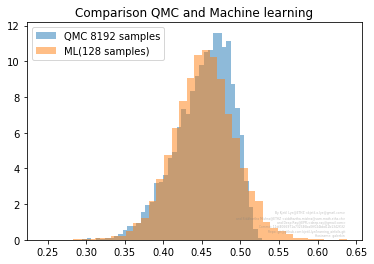

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


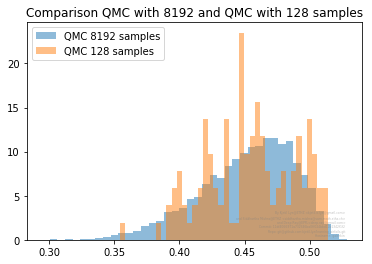

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


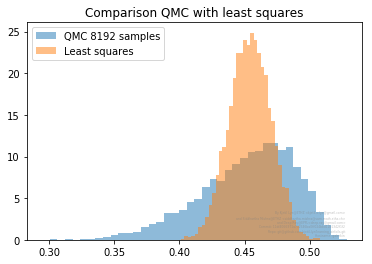

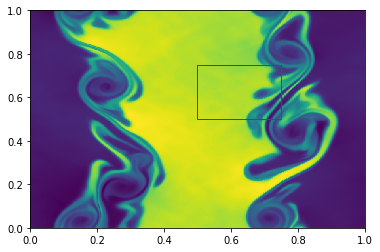

0.4995893526435569
[[256, 256], [384, 384]]
65536
0.4629142696236064
[[256, 256], [384, 384]]
65536
0.49250918675816796
[[256, 256], [384, 384]]
65536
0.4021652645692253
[[256, 256], [384, 384]]
65536
0.4587417510786014
[[256, 256], [384, 384]]
65536
0.4493331355774448
[[256, 256], [384, 384]]
65536
0.42403054842481336
[[256, 256], [384, 384]]
65536
0.4938934698405434
[[256, 256], [384, 384]]
65536
0.49312505360515296
[[256, 256], [384, 384]]
65536
0.4097051538183261
[[256, 256], [384, 384]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


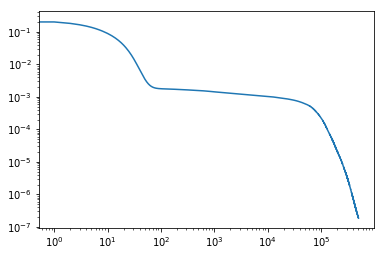

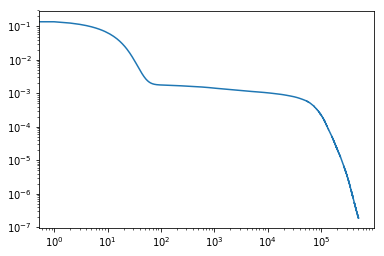

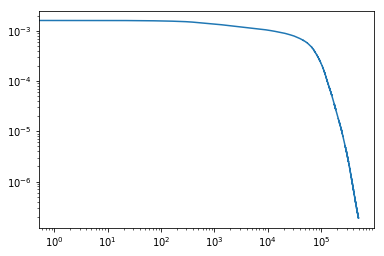

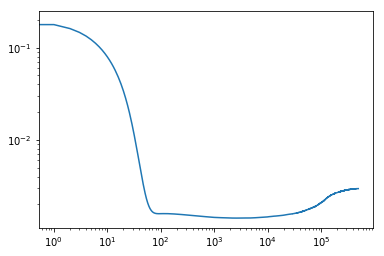

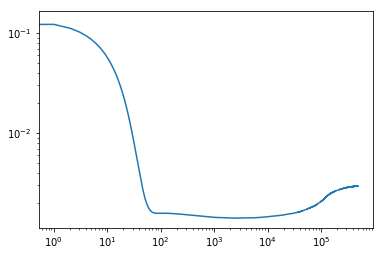

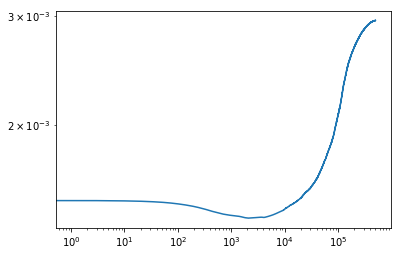

(8192,)
(8192, 1)


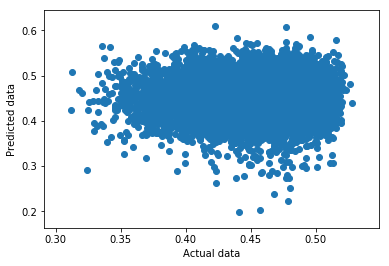

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_61 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_62 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_63 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 22)                462       
__________

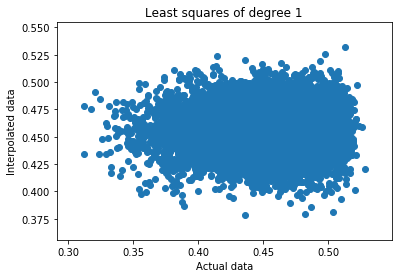

variance single level = 0.001326
variance diff ml = 0.003062 
speedup = 0.216500
(8192,)
variance_diff_interpolate = 0.001749
mean_qmc = 0.451570
mean_ml = 0.450755
mean_few_qmc = 19.843750
mean_lsq = 0.455151
(8192,)
mean_mlmlmc = 0.450756
var_qmc = 0.001326
var_ml = 0.001796
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000427
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


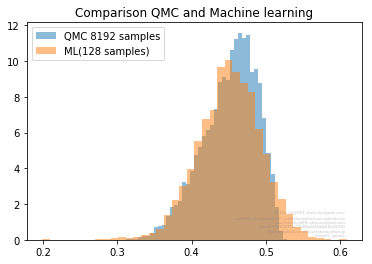

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


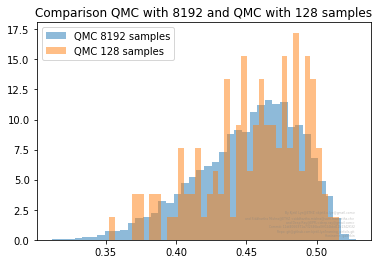

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


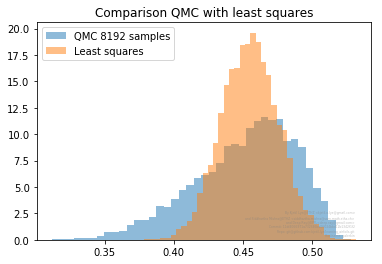

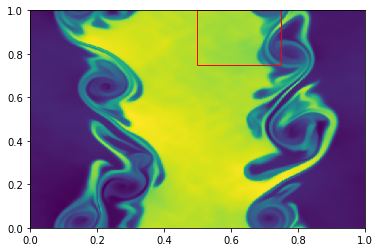

0.4995893526435569
[[256, 384], [384, 512]]
65536
0.45699028478622966
[[256, 384], [384, 512]]
65536
0.4435432585391511
[[256, 384], [384, 512]]
65536
0.3832188475865162
[[256, 384], [384, 512]]
65536
0.448271541957575
[[256, 384], [384, 512]]
65536
0.4461394056107646
[[256, 384], [384, 512]]
65536
0.46095800842151674
[[256, 384], [384, 512]]
65536
0.4320045710187088
[[256, 384], [384, 512]]
65536
0.45765211826493624
[[256, 384], [384, 512]]
65536
0.4735691999532967
[[256, 384], [384, 512]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


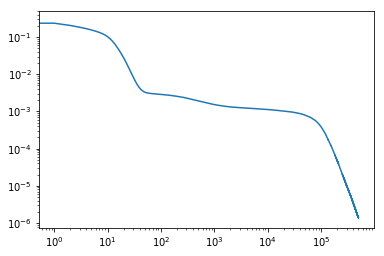

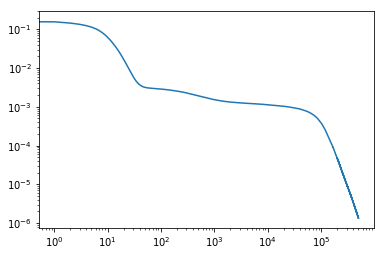

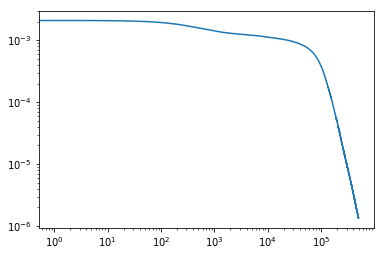

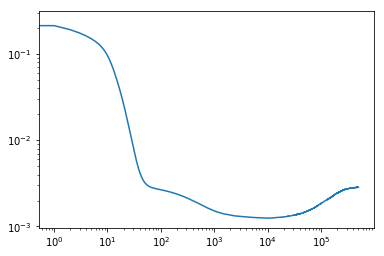

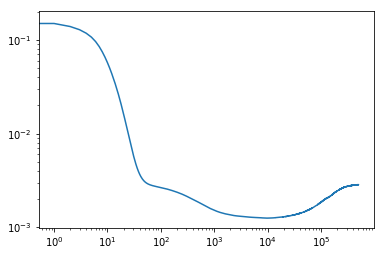

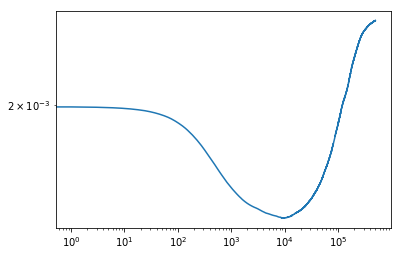

(8192,)
(8192, 1)


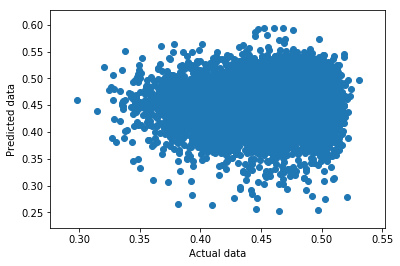

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_67 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_68 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_69 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 22)                462       
__________

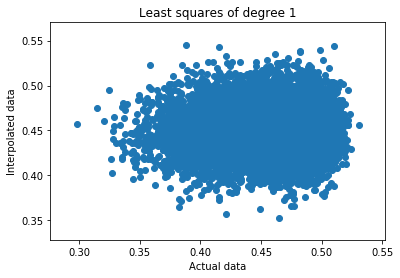

variance single level = 0.001278
variance diff ml = 0.002786 
speedup = 0.229440
(8192,)
variance_diff_interpolate = 0.001908
mean_qmc = 0.452396
mean_ml = 0.449678
mean_few_qmc = 19.843750
mean_lsq = 0.450941
(8192,)
mean_mlmlmc = 0.449678
var_qmc = 0.001278
var_ml = 0.001559
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000665
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


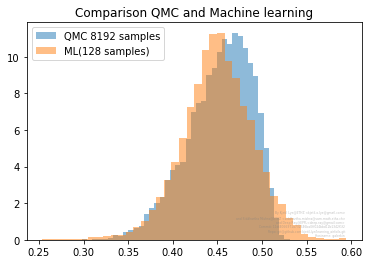

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


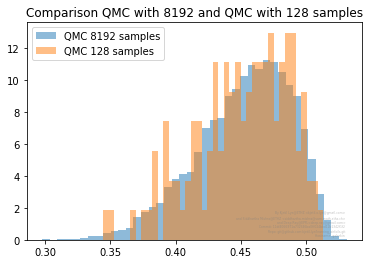

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


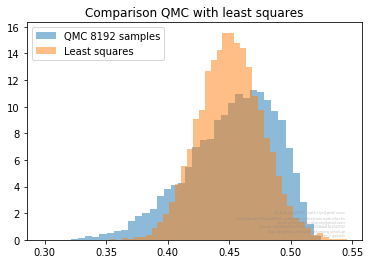

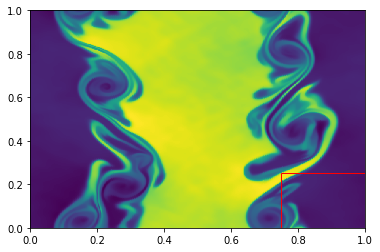

0.25041064735644336
[[384, 0], [512, 128]]
65536
0.2668871354924236
[[384, 0], [512, 128]]
65536
0.3077643992130416
[[384, 0], [512, 128]]
65536
0.3482324795593005
[[384, 0], [512, 128]]
65536
0.26980957148768153
[[384, 0], [512, 128]]
65536
0.29838600346364647
[[384, 0], [512, 128]]
65536
0.3008978127661577
[[384, 0], [512, 128]]
65536
0.2820446457274158
[[384, 0], [512, 128]]
65536
0.3370259124707004
[[384, 0], [512, 128]]
65536
0.30070402265340235
[[384, 0], [512, 128]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


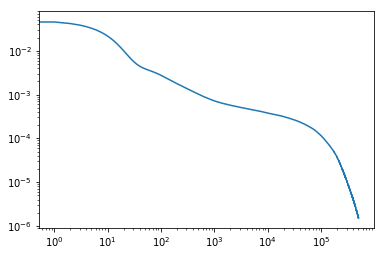

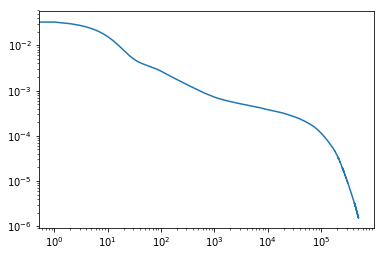

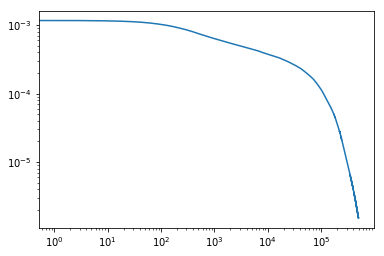

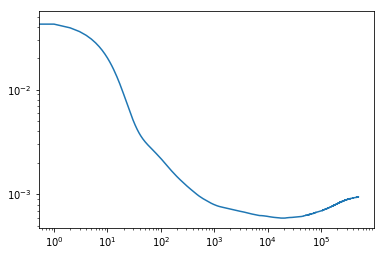

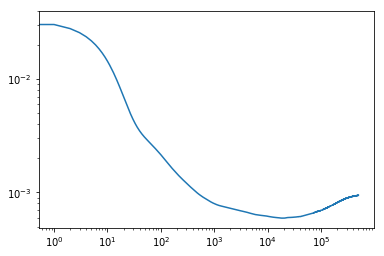

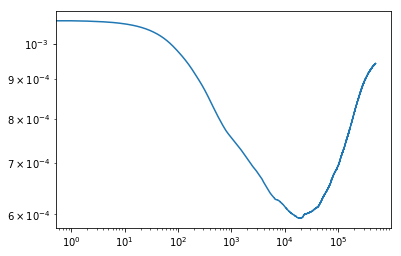

(8192,)
(8192, 1)


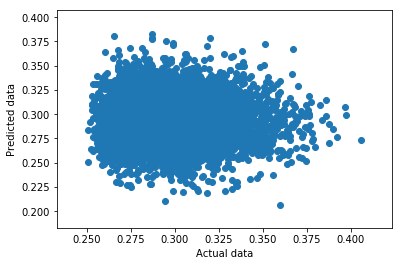

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_73 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_74 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_75 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 22)                462       
__________

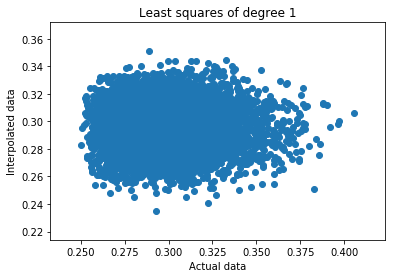

variance single level = 0.000493
variance diff ml = 0.000964 
speedup = 0.255619
(8192,)
variance_diff_interpolate = 0.000725
mean_qmc = 0.298064
mean_ml = 0.293573
mean_few_qmc = 19.843750
mean_lsq = 0.295375
(8192,)
mean_mlmlmc = 0.293574
var_qmc = 0.000493
var_ml = 0.000466
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000239
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


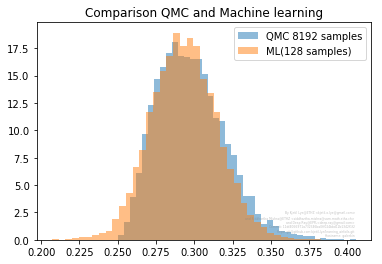

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


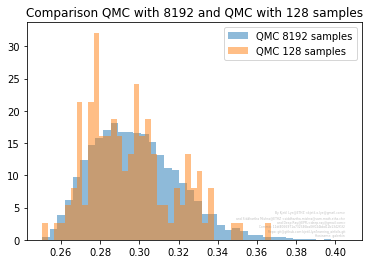

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


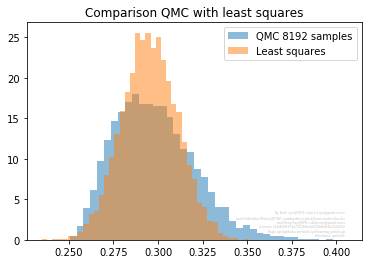

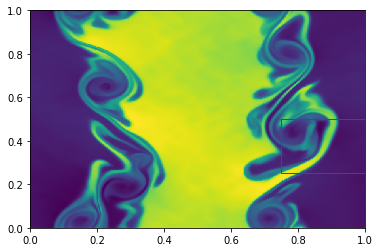

0.25041064735644336
[[384, 128], [512, 256]]
65536
0.2967114504245765
[[384, 128], [512, 256]]
65536
0.30852594776582054
[[384, 128], [512, 256]]
65536
0.3129929635319899
[[384, 128], [512, 256]]
65536
0.30162293226520287
[[384, 128], [512, 256]]
65536
0.3047329001851522
[[384, 128], [512, 256]]
65536
0.3109053545794194
[[384, 128], [512, 256]]
65536
0.2813183349408967
[[384, 128], [512, 256]]
65536
0.3030243498195663
[[384, 128], [512, 256]]
65536
0.3060426593846298
[[384, 128], [512, 256]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


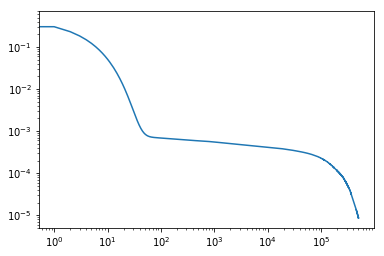

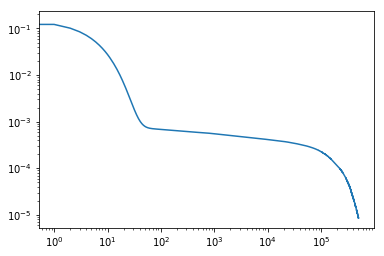

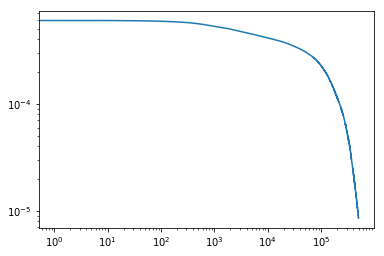

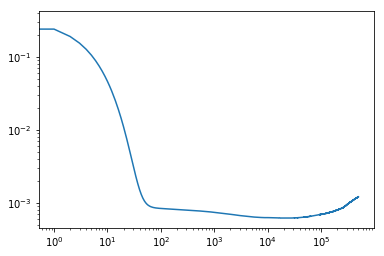

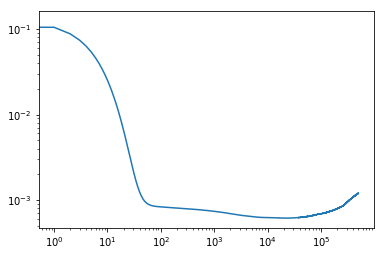

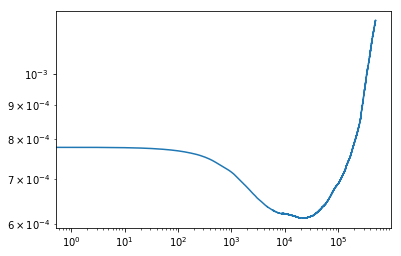

(8192,)
(8192, 1)


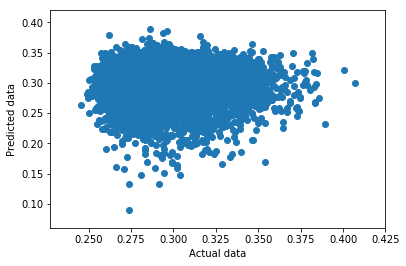

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_79 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 22)                462       
_________________________________________________________________
activation_80 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 20)                460       
_________________________________________________________________
activation_81 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 22)                462       
__________

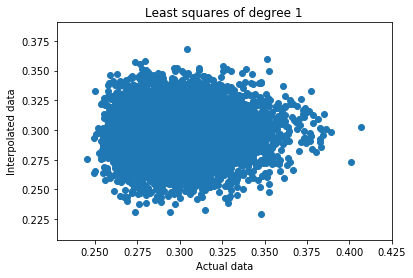

variance single level = 0.000484
variance diff ml = 0.001259 
speedup = 0.192137
(8192,)
variance_diff_interpolate = 0.000831
mean_qmc = 0.298174
mean_ml = 0.295408
mean_few_qmc = 19.843750
mean_lsq = 0.297460
(8192,)
mean_mlmlmc = 0.295410
var_qmc = 0.000484
var_ml = 0.000797
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000354
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


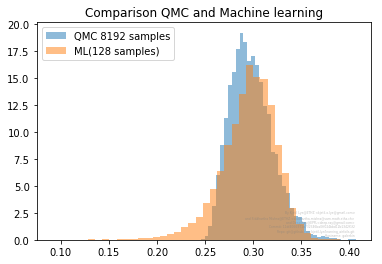

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


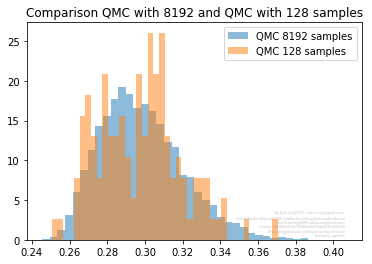

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


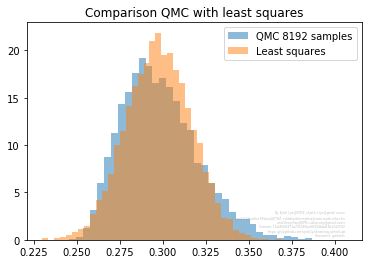

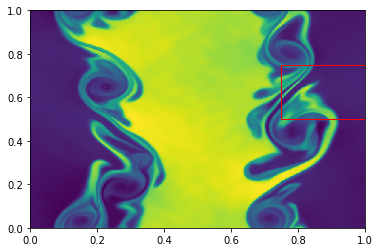

0.25041064735644336
[[384, 256], [512, 384]]
65536
0.28586161770439733
[[384, 256], [512, 384]]
65536
0.29270082514483786
[[384, 256], [512, 384]]
65536
0.2828296387035299
[[384, 256], [512, 384]]
65536
0.3055295249006095
[[384, 256], [512, 384]]
65536
0.2898353102057242
[[384, 256], [512, 384]]
65536
0.28001502453459104
[[384, 256], [512, 384]]
65536
0.2917491793125788
[[384, 256], [512, 384]]
65536
0.286293308489184
[[384, 256], [512, 384]]
65536
0.3017455532737897
[[384, 256], [512, 384]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


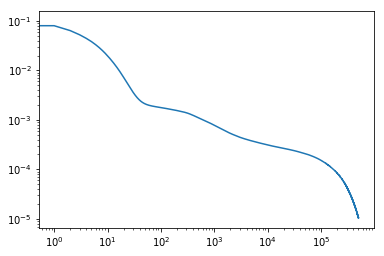

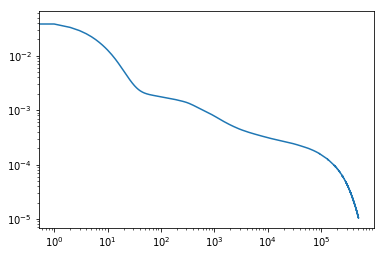

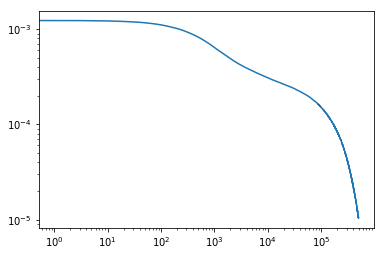

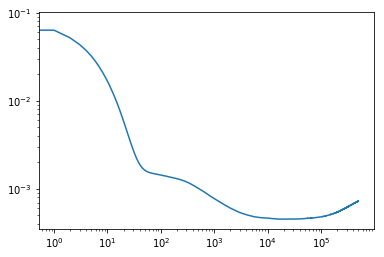

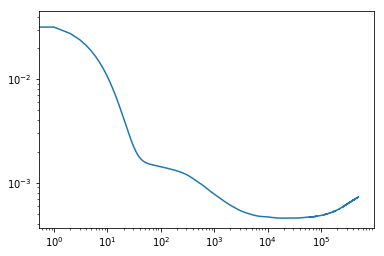

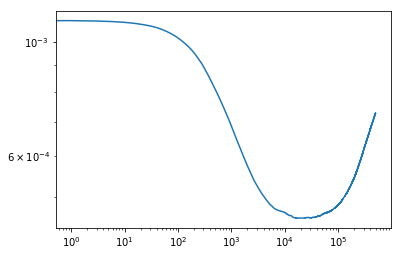

(8192,)
(8192, 1)


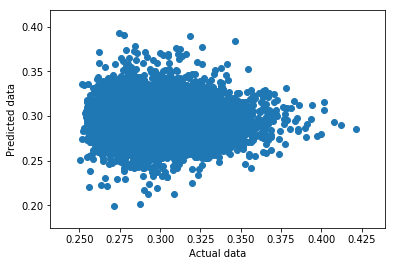

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 20)                820       
_________________________________________________________________
activation_85 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 22)                462       
_________________________________________________________________
activation_86 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 20)                460       
_________________________________________________________________
activation_87 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 22)                462       
__________

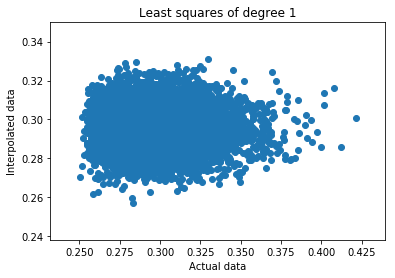

variance single level = 0.000500
variance diff ml = 0.000844 
speedup = 0.296607
(8192,)
variance_diff_interpolate = 0.000608
mean_qmc = 0.298460
mean_ml = 0.293972
mean_few_qmc = 19.843750
mean_lsq = 0.296034
(8192,)
mean_mlmlmc = 0.293973
var_qmc = 0.000500
var_ml = 0.000353
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000103
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


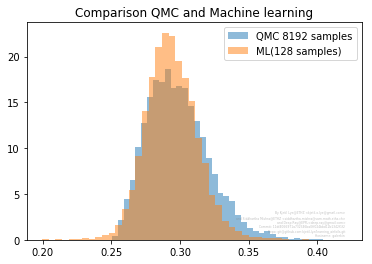

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


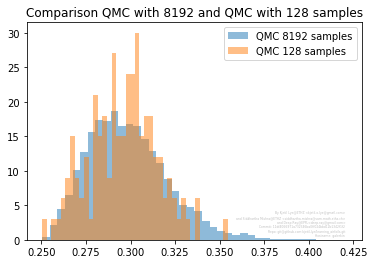

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


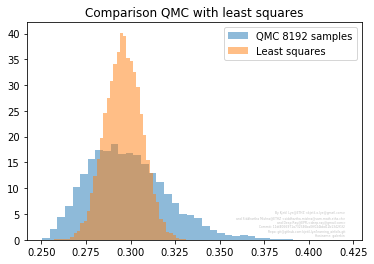

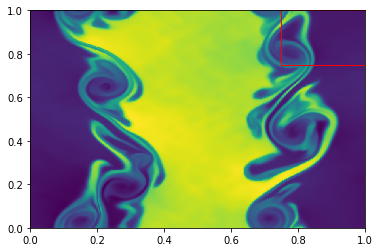

0.25041064735644336
[[384, 384], [512, 512]]
65536
0.31502397252200287
[[384, 384], [512, 512]]
65536
0.29402230925685247
[[384, 384], [512, 512]]
65536
0.2663425799462627
[[384, 384], [512, 512]]
65536
0.28195047481706864
[[384, 384], [512, 512]]
65536
0.28345076958082593
[[384, 384], [512, 512]]
65536
0.27381502203771746
[[384, 384], [512, 512]]
65536
0.3195517028031891
[[384, 384], [512, 512]]
65536
0.28198271733046953
[[384, 384], [512, 512]]
65536
0.279910594110755
[[384, 384], [512, 512]]
65536
8191
<class 'numpy.ndarray'>
(8192,)


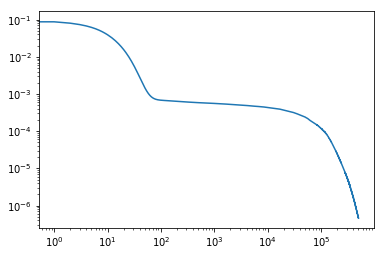

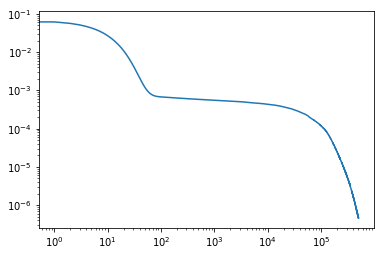

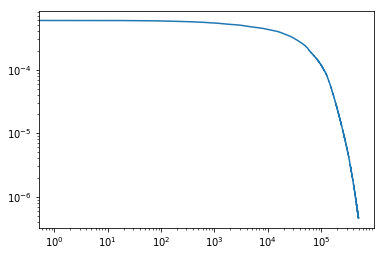

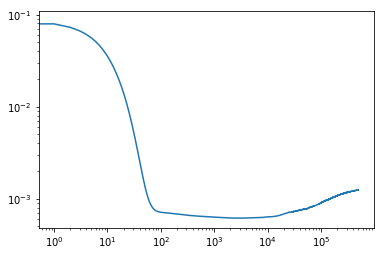

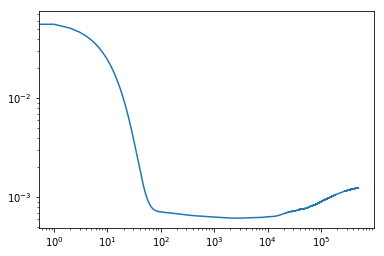

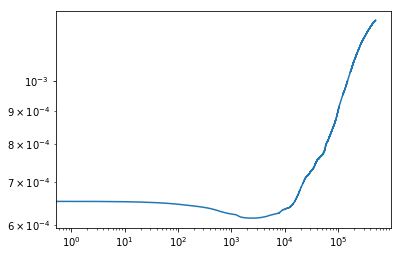

(8192,)
(8192, 1)


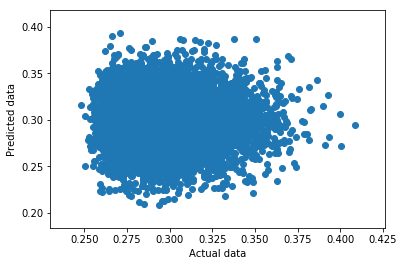

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 20)                820       
_________________________________________________________________
activation_91 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 22)                462       
_________________________________________________________________
activation_92 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 20)                460       
_________________________________________________________________
activation_93 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 22)                462       
__________

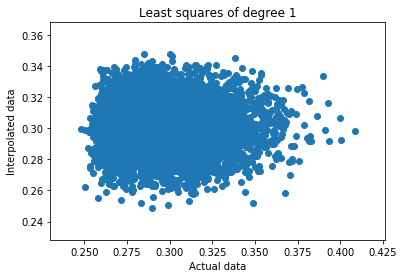

variance single level = 0.000493
variance diff ml = 0.001157 
speedup = 0.213032
(8192,)
variance_diff_interpolate = 0.000697
mean_qmc = 0.298366
mean_ml = 0.300184
mean_few_qmc = 19.843750
mean_lsq = 0.300524
(8192,)
mean_mlmlmc = 0.300184
var_qmc = 0.000493
var_ml = 0.000677
var_few_qmc = 14976.605225
(8192, 40)
var_lsq = 0.000212
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


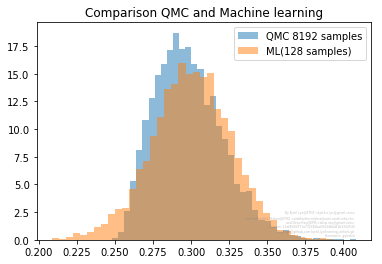

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


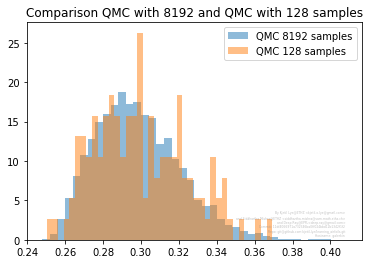

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


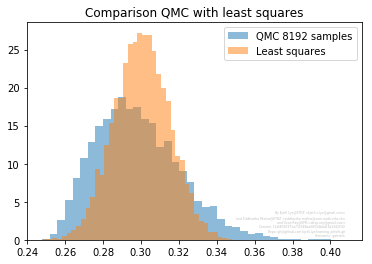

In [7]:
variables = ['rho', 'E', 'p']

points = []

for x in [0.0,0.25,0.5,0.75]:
    for y in [0.0,0.25,0.5,0.75]:
        points.append([x,y])
epochs = [500000, 5000]

for epoch in epochs:
    for v in variables:
        for p in points:
        
            try:
                prefix = '%s_%f_%f' % (v, p[0], p[1])
                prefix = prefix.replace('.','_')
                showAndSave.prefix = 'kh_%d_%s' % (epoch, prefix)

                network, data, parameters = get_network_interpolate_qmc(data_path, AreaFunctional(integrate_coordinate=p,variable=v), epoch)
            except Exception as e:
                print(e)
                pass


In [8]:
samples = get_samples(data_path, AreaFunctional())

0.4508587522090691
[[281, 179], [409, 307]]
65536
0.39171593360394247
[[281, 179], [409, 307]]
65536
0.46551893180129506
[[281, 179], [409, 307]]
65536
0.40871994729098693
[[281, 179], [409, 307]]
65536
0.4556669283214425
[[281, 179], [409, 307]]
65536
0.42151572228464784
[[281, 179], [409, 307]]
65536
0.44286280499192354
[[281, 179], [409, 307]]
65536
0.4279633696688092
[[281, 179], [409, 307]]
65536
0.4144012764528778
[[281, 179], [409, 307]]
65536
0.40356393577133987
[[281, 179], [409, 307]]
65536
8191


[0.45085875 0.39171593 0.46551893 ... 0.40834451 0.45144968 0.42880289]


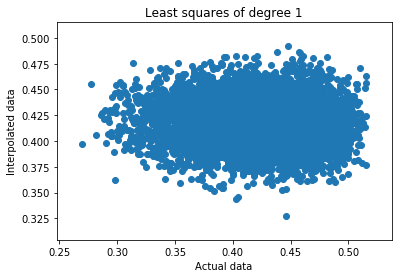

0.4196676291219611
0.4204606491342804
0.0016547239945216671
0.0004224001428405972


In [9]:
parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
parameters = loadtxt(parameter_path)
from sklearn import linear_model
data = samples

print(data)
reg_size = 128
reg = linear_model.LinearRegression()
y_train = data[:reg_size]
coeffs = reg.fit(parameters[:reg_size,:], y_train)

evaluated_lsq = coeffs.predict(parameters)
plt.scatter(data, evaluated_lsq)
plt.title('Least squares of degree 1')
plt.xlabel("Actual data")
plt.ylabel("Interpolated data")
plt.show()
print(sum(evaluated_lsq)/len(evaluated_lsq))
print(sum(data)/len(data))
print(var(data))
print(var(evaluated_lsq))

In [10]:
func=AreaFunctional()
with netCDF4.Dataset(data_path) as f:
    d = f.variables['sample_10_rho'][:,:,0]
    r = func(d)
    print(r)

0.4237384807612413
[[281, 179], [409, 307]]
65536
0.4237384807612413


In [11]:

a=linspace(0,10)
print(isnan(a))
print(type(samples))
print(type(a))
print(samples.shape)
print(a.shape)
print(a.dtype)
print(samples.dtype)
samples2 = samples.astype(float64)
print(samples[0])
print(isnan(samples2))


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(8192,)
(50,)
float64
float64
0.4508587522090691
[False False False ... False False False]
